In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [2]:
# Creates the antecedents, or inputs, to decide the most efficient solution.
risk = ctrl.Antecedent(np.arange(0, 101, 1), 'risk')            # Risk of the generated action
time = ctrl.Antecedent(np.arange(0, 101, 1), 'time')            # Time to execute the action
energy = ctrl.Antecedent(np.arange(0, 101, 1), 'energy')        # Considers the current energy of the system.
complexity = ctrl.Antecedent(np.arange(0, 101, 1), 'complexity')# 
impact = ctrl.Antecedent(np.arange(0, 101, 1), 'impact')        # How much it would affect the mission

# Output variable to decide the best course of action, the fuzzy set of each action depends on the State (S) of the system
action = ctrl.Consequent(np.arange(0, 11, 1), 'action')

In [3]:
# Fuzzy sets for input variables, the sets are splitted in 3 different categories which are (low, medium, high)
risk.automf(3, variable_type='quantity')
time.automf(3, 'quantity')
energy.automf(3, 'quantity')
complexity.automf(3, 'quantity')
impact.automf(3, 'quantity')

In [4]:
# Create the possible actions for each state S
def actions(state):
    action.terms = {} # Clear the terms
    if state == "S1": # Normal
        action['remain_normal'] = fuzz.trapmf(action.universe, [0, 0, 8, 10])
        action['emergency_landing'] = fuzz.trapmf(action.universe, [9, 9, 10, 10])
        return 
    elif state == "S2": # GPS Spoofing
        action['restore_attack'] = fuzz.trimf(action.universe, [0, 0, 3])
        action['change_route'] = fuzz.trimf(action.universe, [1, 3, 5])
        action['activate_redundancy'] = fuzz.trimf(action.universe, [3, 5, 7])
        action['use_occupancy_maps'] = fuzz.trimf(action.universe, [5, 7, 9])
        action['emergency_landing'] = fuzz.trimf(action.universe, [7, 10, 10])
        return
    elif state == "S3": # Jamming GPS
        action['change_altitude'] = fuzz.trimf(action.universe, [0, 0, 3])
        action['restore_system'] = fuzz.trapmf(action.universe, [1, 4, 5, 7])
        action['activate_redundancy'] = fuzz.trapmf(action.universe, [3, 6, 7, 9])
        action['emergency_landing'] = fuzz.trimf(action.universe, [7, 10, 10])
        return
    elif state == "S4": # Engine
        action['activate_redundancy'] = fuzz.trapmf(action.universe, [0, 0, 4, 6])
        action['emergency_landing'] = fuzz.trapmf(action.universe, [4 ,7, 10, 10])
    elif state == "S5": # Aileron or elevator
        action['change_altitude'] = fuzz.trapmf(action.universe, [0, 0, 4, 6])
        action['emergency_landing'] = fuzz.trapmf(action.universe, [4 ,7, 10, 10])
        return
    elif state == "S6": # Rudder
        action['navigation_adjustment'] = fuzz.trapmf(action.universe, [0, 0, 4, 6])
        action['emergency_landing'] = fuzz.trapmf(action.universe, [4 ,7, 10, 10])
        return

In [27]:
# Create the rules for the fuzzy system
def rules(state):
    if state == "S1": # Normal
        return [
            ctrl.Rule(~risk['high']  | (~energy['low'] & ~time['low']), action['remain_normal']),
            ctrl.Rule(risk['high'] & (energy['low'] & time['low']) | ~impact['low'] & ~complexity['low'], action['emergency_landing'])
        ]
    elif state == "S2": # GPS Spoofing
        return [
            ctrl.Rule(risk['low'] & impact['low'] & complexity['low'], action['restore_attack']),
            ctrl.Rule(time['high'] & energy['average'] & impact['average'], action['change_route']),
            ctrl.Rule(time['average'] & energy['average'] & impact['average'], action['activate_redundancy']),
            ctrl.Rule(time['low'] & energy['average'] & impact['high'], action['use_occupancy_maps']),
            ctrl.Rule((risk['high'] | complexity['high']) & energy['low'], action['emergency_landing'])
        ]
    elif state == "S3": # Jamming GPS
        return [
            ctrl.Rule(risk['low'] & impact['low'] & complexity['low'], action['change_altitude']),
            ctrl.Rule(time['high'] & energy['average'] & impact['average'], action['restore_system']),
            ctrl.Rule(complexity['average'] & energy['average'] & time['average'], action['activate_redundancy']),
            ctrl.Rule((risk['high'] | complexity['high']) & energy['low'], action['emergency_landing'])
        ]
    elif state == "S4": # Engine
        return [
            ctrl.Rule((risk['average'] | complexity['average']) & energy['high'], action['activate_redundancy']),
            ctrl.Rule((risk['high'] | complexity['high']) & energy['low'], action['emergency_landing'])
        ] 
    elif state == "S5": # Aileron
        return [
            ctrl.Rule((risk['average'] | complexity['average']) & energy['high'], action['change_altitude']),
            ctrl.Rule((risk['high'] | complexity['high']) & energy['low'], action['emergency_landing'])
        ] 
    elif state == "S6": # Rudder
        return [
            ctrl.Rule((risk['average'] | complexity['average']) & energy['high'], action['navigation_adjustment']),
            ctrl.Rule((risk['high'] | complexity['high']) & energy['low'], action['emergency_landing'])
        ] 


In [10]:
def decision_name(state, action_value):
    if state == "S1":
        if action_value < 5:
            return "Remain Normal"
        else:
            return "Emergency Landing"
    elif state == "S2": 
        if action_value < 2:
            return "Restore Attack"
        elif action_value < 4:
            return "Change Route"
        elif action_value < 6:
            return "Activate Redundancy"
        elif action_value < 8:
            return "Use Occupancy Maps"
        else:
            return "Emergency Landing"
    elif state == "S3":
        if action_value < 2:
            return "Change Altitude"
        elif action_value < 5:
            return "Restore System"
        elif action_value < 8:
            return "Activate Redundancy"
        else:
            return "Emergency Landing"
    elif state == "S4":
        if action_value < 5:
            return "Activate Redundancy"
        else:
            return "Emergency Landing"
    elif state == "S5":
        if action_value < 5:
            return "Change Altitude"
        else:
            return "Emergency Landing"
    elif state == "S6":
        if action_value < 5:
            return "Navigation Adjustment"
        else:
            return "Emergency Landing"
        

Change Route


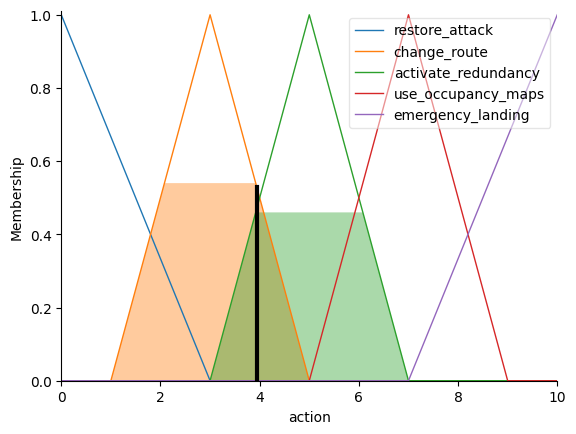

In [37]:
# Function to get the appropriate action based on the current state and inputs
def get_action(state, risk_value = 0, time_value = 0, energy_value = 0, complexity_value = 0, impact_value = 0):
    actions(state)
    rule_set = rules(state)
    action_ctrl = ctrl.ControlSystem(rule_set)
    action_simulation = ctrl.ControlSystemSimulation(action_ctrl)

    action_simulation.input['risk'] = risk_value
    action_simulation.input['time'] = time_value
    action_simulation.input['energy'] = energy_value
    action_simulation.input['complexity'] = complexity_value
    action_simulation.input['impact'] = impact_value

    action_simulation.compute()
    #action_simulation.print_state()
    action.view(sim = action_simulation)
    action_value = action_simulation.output['action']
    return decision_name(state, action_value)

print(get_action(state= "S2", risk_value= 50, time_value= 77, energy_value= 50,complexity_value= 50,impact_value= 50))

In [8]:
print(get_action(state= "S1", risk_value= 99, time_value= 1,energy_value= 0,complexity_value= 99,impact_value= 100))

 Antecedents 
Antecedent: risk                    = 99
  - low                             : 0.0
  - average                         : 0.02
  - high                            : 0.98
Antecedent: energy                  = 0
  - low                             : 1.0
  - average                         : 0.0
  - high                            : 0.0
Antecedent: complexity              = 99
  - low                             : 0.0
  - average                         : 0.02
  - high                            : 0.98
Antecedent: impact                  = 100
  - low                             : 0.0
  - average                         : 0.0
  - high                            : 1.0
Antecedent: time                    = 1
  - low                             : 0.98
  - average                         : 0.02
  - high                            : 0.0

 Rules 
RULE #0:
  IF (NOT-risk[high]) AND (NOT-energy[low]) THEN action[remain_normal]
	AND aggregation function : fmin
	OR aggregation function